# Setup

In [1]:
cd /home/mitchellkwong/onedrive/workbins/BT4013/BT4013-toofdoctor

/home/mitchellkwong/onedrive/workbins/BT4013/BT4013-toofdoctor


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import datetime
import pickle

import numpy as np
import pandas as pd
import pmdarima as pm
from tqdm import tqdm

import utils

# Models

In [3]:
from models.numeric.arima import ArimaWrapper

# Verify persistence is working

In [4]:
import os
import pickle

def variable_scheme(y):
    """Returns the last 10 close prices in a train split"""
    rows = y.index < datetime(2021, 1, 1)
    cols = 'CLOSE'
    num_y = 10
    return y.loc[rows, cols].tail(num_y)

data = utils.load_futures_data()
models = {}

# Fit all models
for future in tqdm(data):
    models[future] = ArimaWrapper(y=variable_scheme)
    models[future].fit(data, future, error_action='ignore')

# Save all models
for future in tqdm(data):
    with open(f'{future}.p', 'wb') as f:
        pickle.dump(models[future], f)

# Prediction for t+1
pred1 = []
for future in tqdm(data):
    pred1.append(models[future].predict(data, future))
    
# Prediction for t+2
pred2 = []
for future in tqdm(data):
    pred2.append(models[future].predict(data, future))

# Reload all models
for future in tqdm(data):
    with open(f'{future}.p', 'rb') as f:
        models[future] = pickle.load(f)

# Prediction for t+1 again
pred3 = []
for future in tqdm(data):
    pred3.append(models[future].predict(data, future))

# Remove temp files
for future in tqdm(data):
    os.remove(f'{future}.p')

assert any(np.array(pred1) != np.array(pred2)) # predictions for t+1 and t+2 should differ
assert all(np.array(pred1) == np.array(pred3)) # predictions for t+1 should match before and after reload

100%|██████████| 88/88 [00:00<00:00, 51978.42it/s]


# Model Tuning

In [5]:
class ArimaRaw(ArimaWrapper):
    SAVED_DIR = 'saved_models/numeric/arima'
    
    def __init__(self):
        super().__init__(y=self.transform_predictor)
    
    def transform_predictor(self, data):
        """Returns the last 50 close prices in a train split"""
        rows = data.index < datetime(2021, 1, 1)
        cols = 'CLOSE'
        y = data.loc[rows, cols]
        return y

class ArimaLinear(ArimaWrapper):
    SAVED_DIR = 'saved_models/numeric/arimalinear'
    
    def __init__(self):
        super().__init__(y=self.transform_predictor)
    
    def transform_predictor(self, data):
        rows = data.index < datetime(2021, 1, 1)
        cols = 'CLOSE'
        y = data.loc[rows, cols]
        y = np.log(y)
        return y

class ArimaNoTrend(ArimaWrapper):
    SAVED_DIR = 'saved_models/numeric/arimanotrend'
    
    def __init__(self):
        super().__init__(y=self.transform_predictor)
    
    def transform_predictor(self, data):
        rows = data.index < datetime(2021, 1, 1)
        cols = 'CLOSE'
        y = data.loc[rows, cols]
        y = np.diff(y)
        return y

class ArimaLinearNoTrend(ArimaWrapper):
    SAVED_DIR = 'saved_models/numeric/arimalinearnotrend'
    
    def __init__(self):
        super().__init__(y=self.transform_predictor)
    
    def transform_predictor(self, data):
        rows = data.index < datetime(2021, 1, 1)
        cols = 'CLOSE'
        y = data.loc[rows, cols]
        y = np.log(y)
        y = np.diff(y)
        return y

In [6]:
candidates = [
    ArimaRaw,
    ArimaLinear,
    ArimaNoTrend,
    ArimaLinearNoTrend,
]
candidates = {model.SAVED_DIR: model for model in candidates}

In [7]:
# Load all models (fit and save if no model exists)
data = utils.load_futures_data()
models = {}
for name, model in candidates.items():
    for future in tqdm(data):
        try:
            with open(f'{model.SAVED_DIR}/{future}.p', 'rb') as f:
                models[name, future] = pickle.load(f)
        except:
            models[name, future] = model()
            models[name, future].fit(data, future, out_of_sample_size=1500, error_action='ignore')
            with open(f'{model.SAVED_DIR}/{future}.p', 'wb') as f:
                pickle.dump(models[name, future], f)

models = pd.DataFrame.from_dict(models, orient='index')
models.index = pd.MultiIndex.from_tuples(models.index, names = ['save_dir', 'future'])
models.columns = ['arima']
models.head()

100%|██████████| 88/88 [00:01<00:00, 72.61it/s]


arima
save_dir                   future                                              
saved_models/numeric/arima F_AD    <__main__.ArimaRaw object at 0x7f7d9eb266d0>
                           F_BO    <__main__.ArimaRaw object at 0x7f7d9eb20110>
                           F_BP    <__main__.ArimaRaw object at 0x7f7d9cd462d0>
                           F_C     <__main__.ArimaRaw object at 0x7f7d9cd56490>
                           F_CC    <__main__.ArimaRaw object at 0x7f7d9cd5c4d0>

In [12]:
models['name'] = models['arima'].apply(lambda x: str(x.model))
models['MSE'] = models['arima'].apply(lambda x: x.model.oob_)
models[['name', 'MSE']].to_csv('model_metrics/arima_summary.csv')

# Model Summary

In [3]:
summary = pd.read_csv('model_metrics/arima_summary.csv')

In [7]:
np.sqrt(summary.groupby('save_dir').mean())

,MSE
save_dir,
saved_models/numeric/arima,146559.598031
saved_models/numeric/arimalinear,0.185371
saved_models/numeric/arimalinearnotrend,0.015150
saved_models/numeric/arimanotrend,9424.600275


# Data Exploration

In [4]:
data = utils.load_futures_data()

In [53]:
?fit

In [70]:
transformations = {
    'raw': lambda x: x,
    'linearize': lambda x: np.log(x),
    'detrend': lambda x: np.diff(x),
    'linearize_detrend': lambda x: np.diff(np.log(x)),
}

metrics = {
    'rsquared': lambda fit: fit.rsquared,
    'pvalue': lambda fit: fit.pvalues[1], 
}

results = pd.DataFrame(
    index = pd.MultiIndex.from_product([utils.futuresList, transformations], names=['future', 'transformation']),
    columns = metrics,
)

for future, name in tqdm(results.index):
    f = transformations[name]
    y = f(data[future]['CLOSE'])
    X = sm.add_constant(np.arange(len(y)))
    fit = sm.OLS(y, X).fit()
    
    for metric, func in metrics.items():
        results.loc[(future, name), metric] = func(fit)

results.head()

100%|██████████| 352/352 [00:00<00:00, 520.01it/s]


rsquared    pvalue
future transformation                       
F_AD   raw                0.100188       0.0
       linearize          0.093799       0.0
       detrend            0.000003  0.882197
       linearize_detrend  0.000006  0.827577
F_BO   raw                0.300287       0.0

In [87]:
import matplotlib.pyplot as plt
from pmdarima.arima import ADFTest, KPSSTest

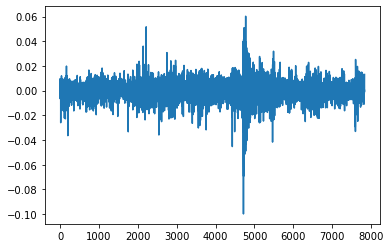

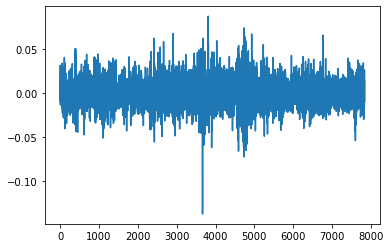

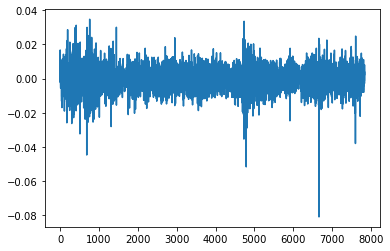

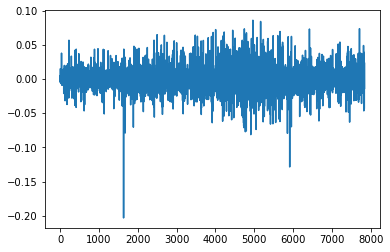

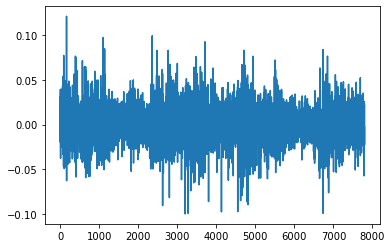

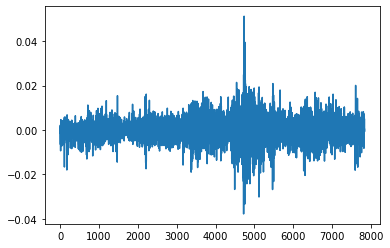

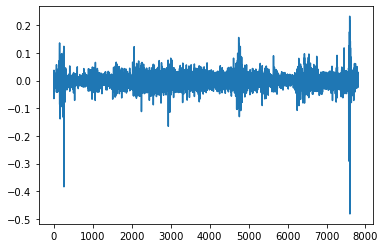

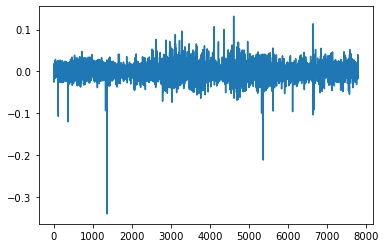

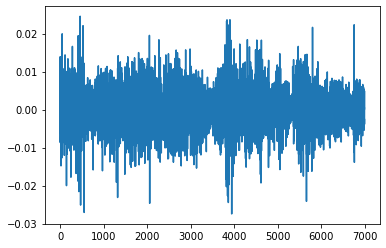

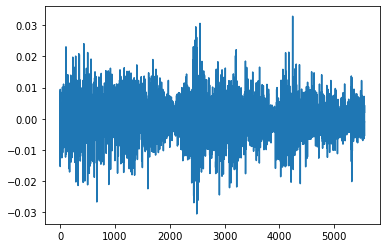

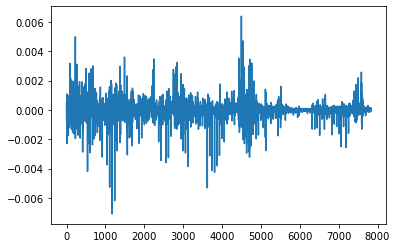

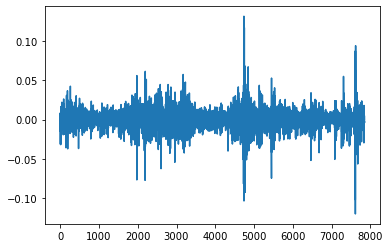

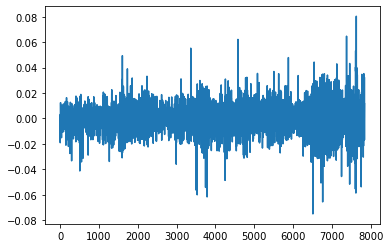

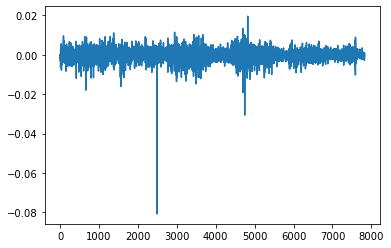

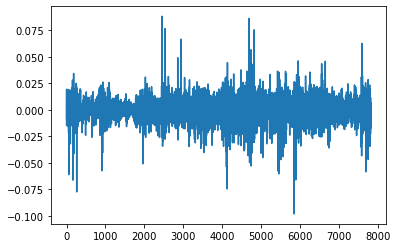

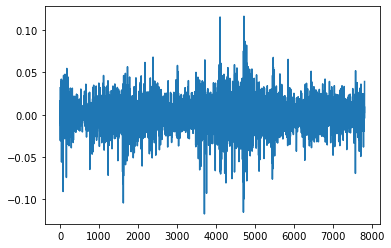

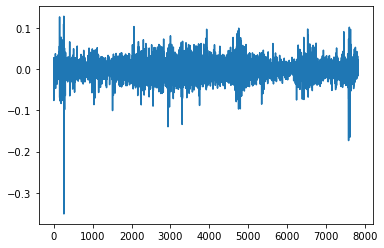

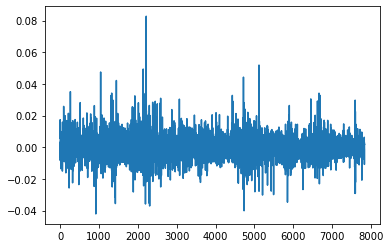

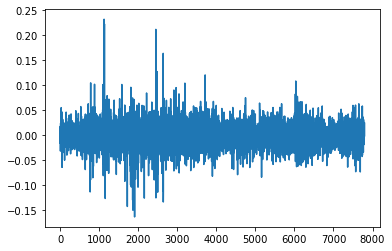

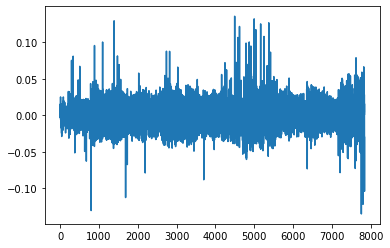

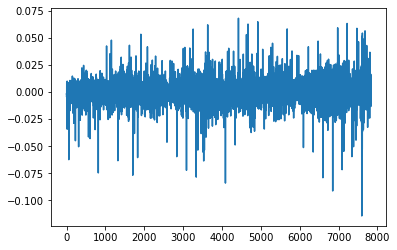

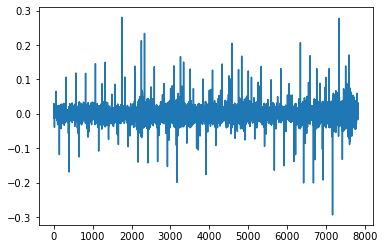

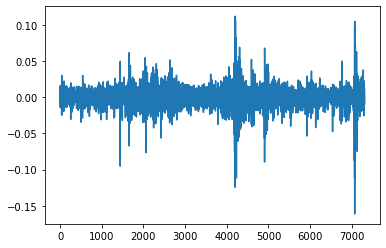

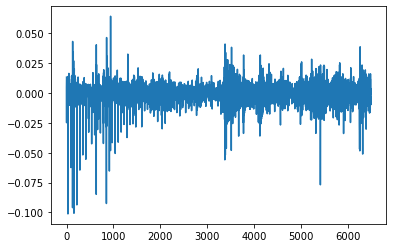

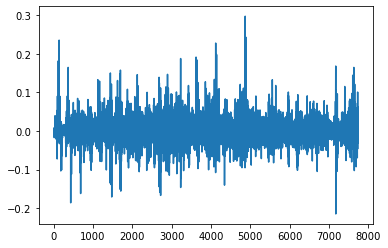

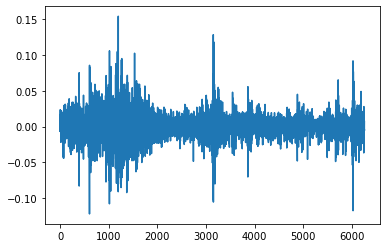

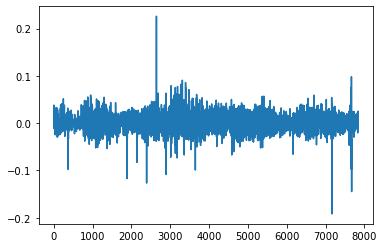

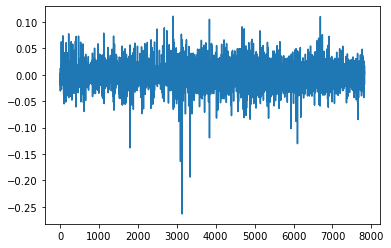

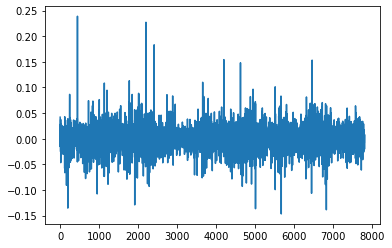

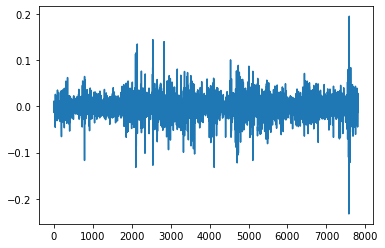

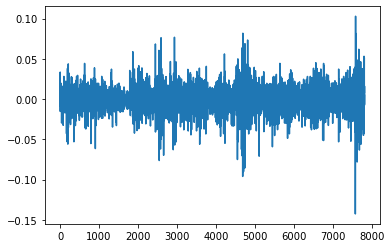

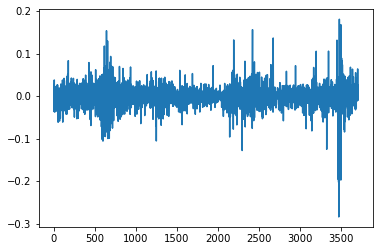

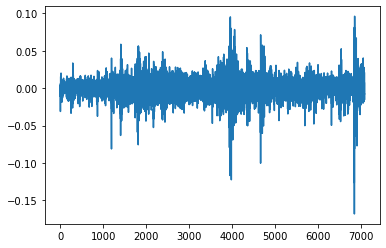

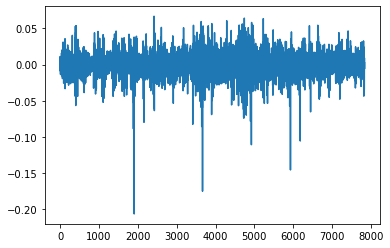

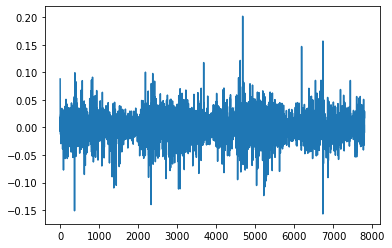

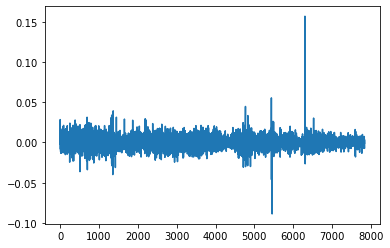

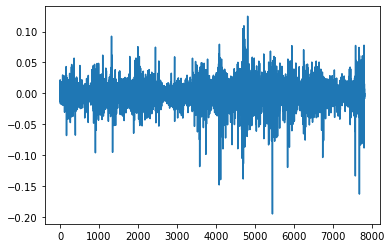

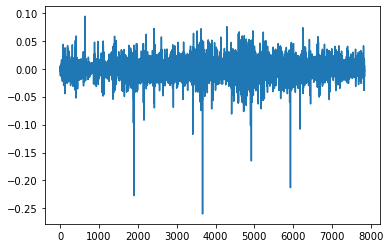

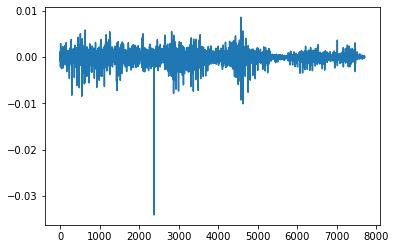

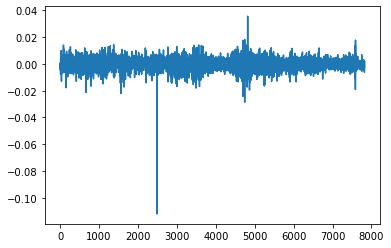

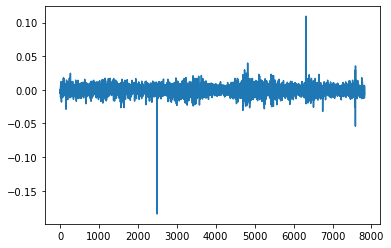

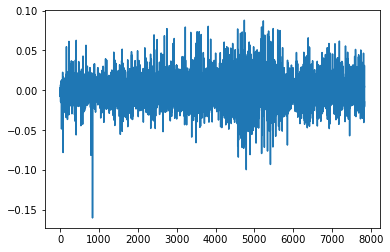

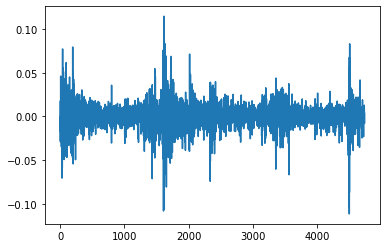

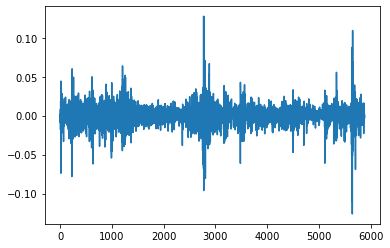

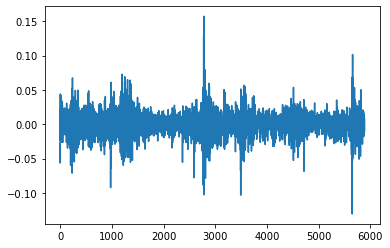

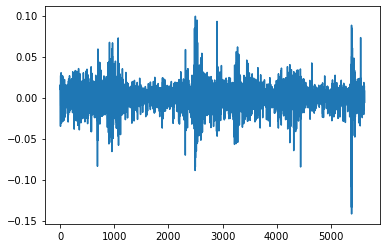

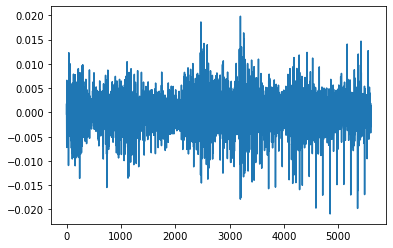

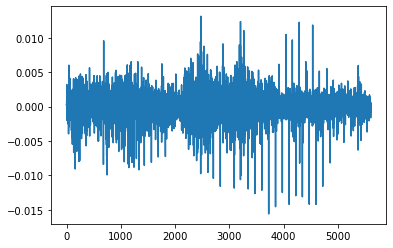

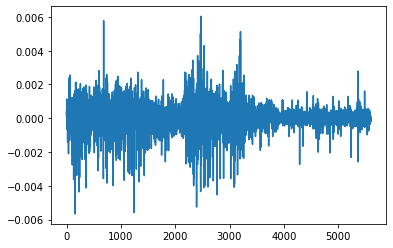

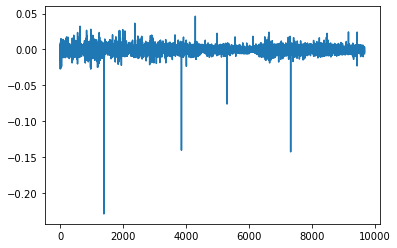

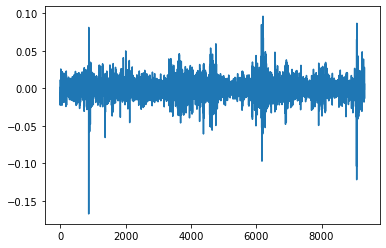

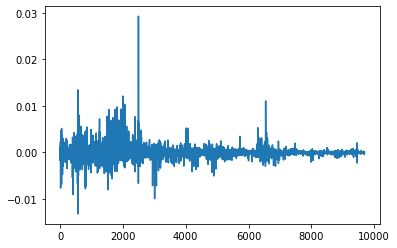

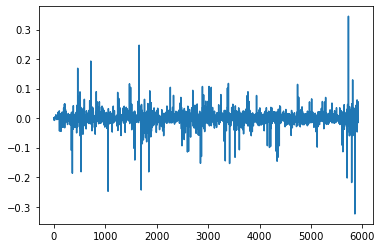

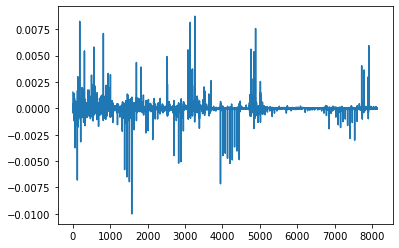

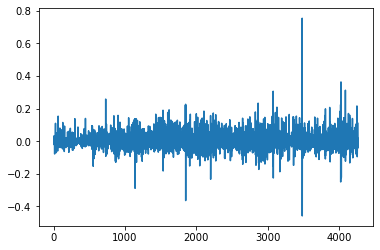

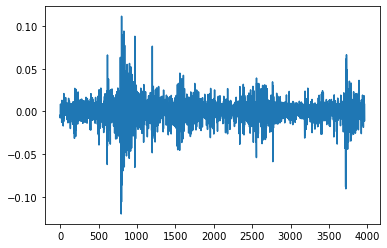

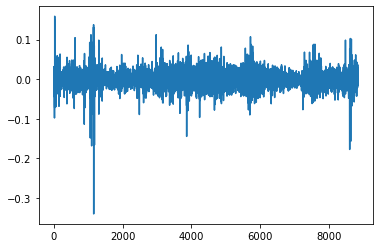

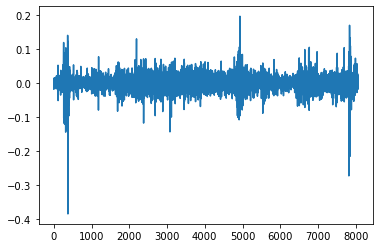

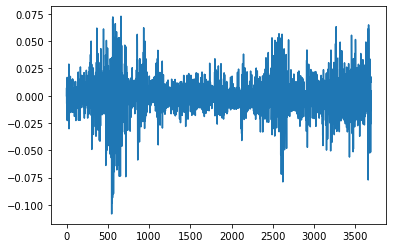

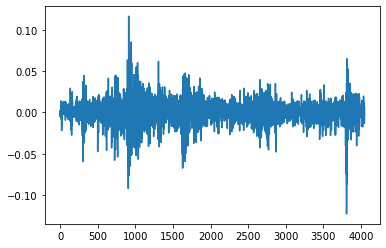

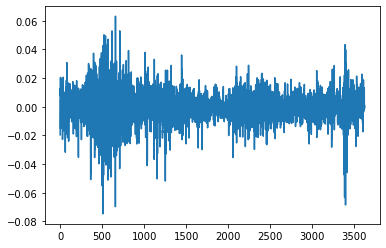

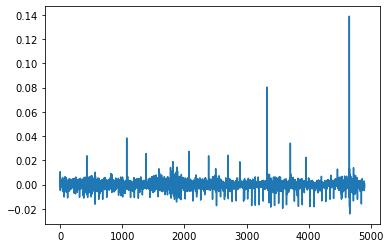

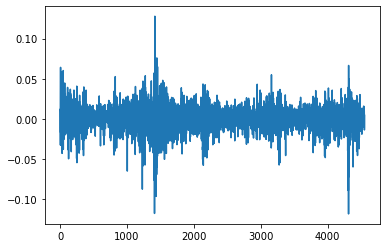

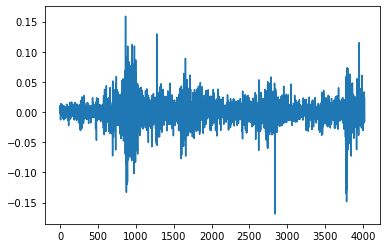

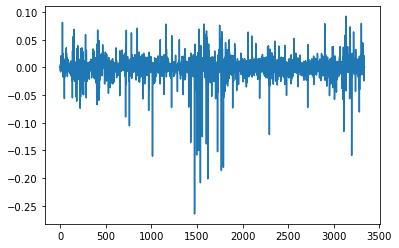

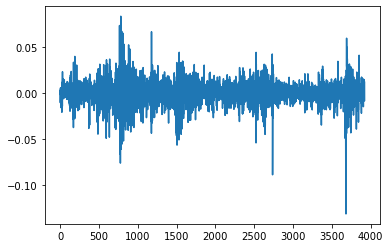

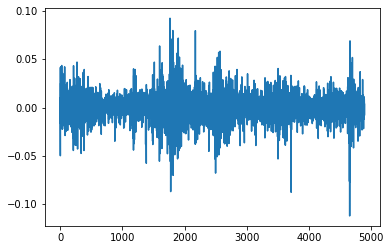

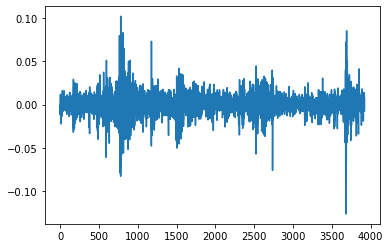

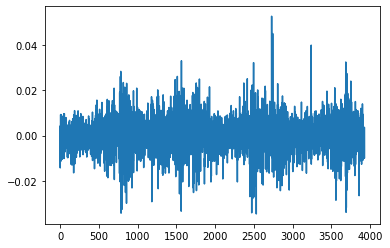

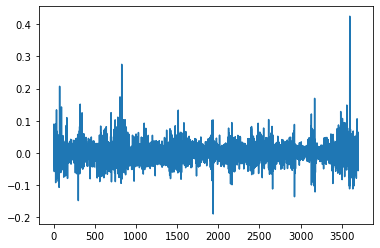

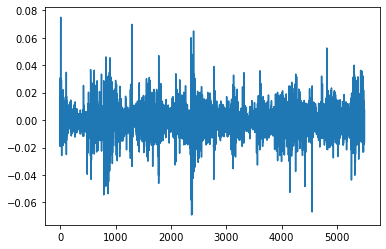

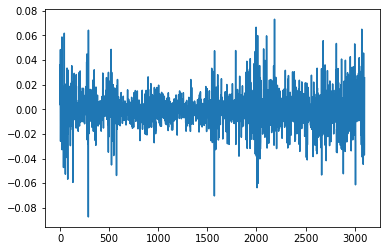

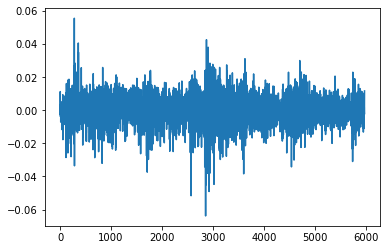

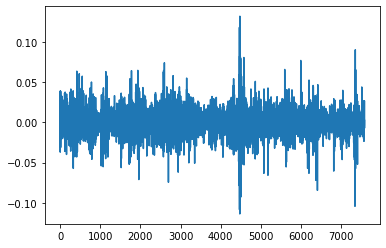

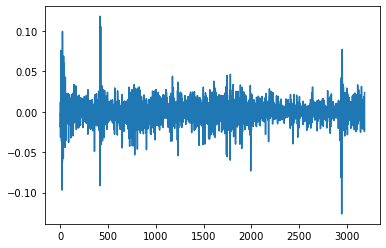

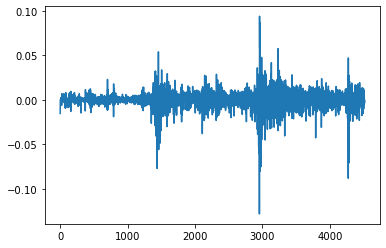

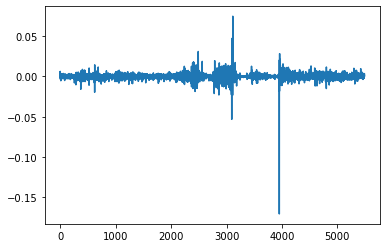

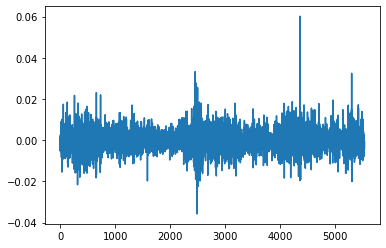

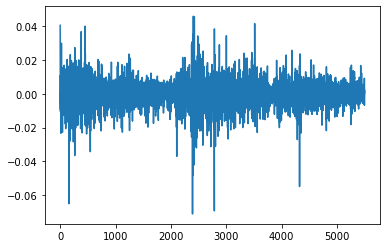

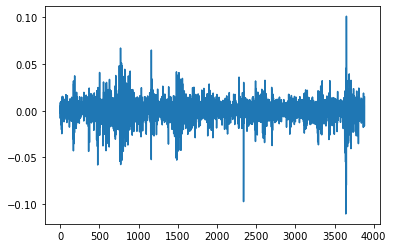

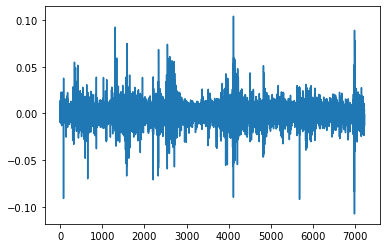

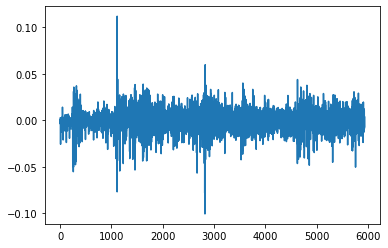

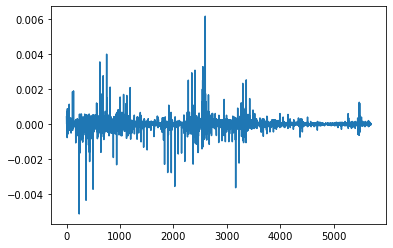

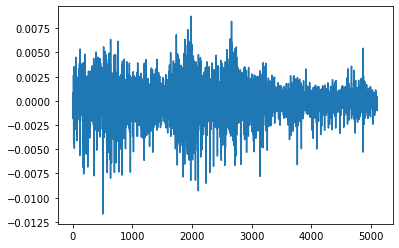

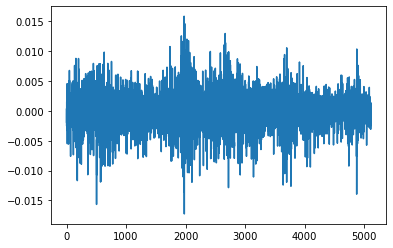

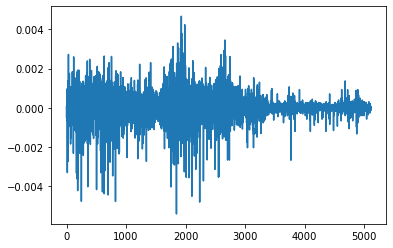

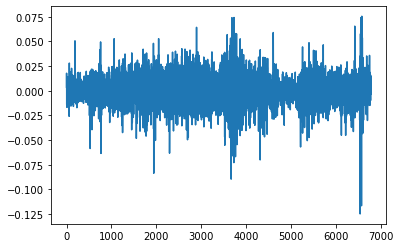

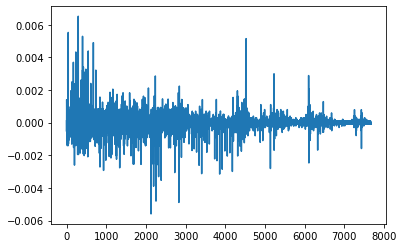

In [118]:
for future in utils.futuresList:
    pd.Series(transformations['linearize_detrend'](data[future]['CLOSE'])).plot()
    plt.show()

In [92]:
?KPSSTest

In [95]:
adf = KPSSTest(alpha=0.05)
adf.should_diff(y)

(0.1, False)

In [72]:
results.reset_index().groupby('future').max(['rsquared', 'pvalue']).transformation.unique()

array(['raw'], dtype=object)

In [ ]:
from pmdarima import AutoARIMA
from pmdarima.arima.utils import ndiffs, diff
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing.base import BaseTransformer

from sklearn.model_selection import GridSearchCV

class Linearize(BaseTransformer):
    def fit(self, y, exogenous):
        return self
    
    def transform(self, y, exogenous):
        return np.log(y)
    
class Detrend(BaseTransformer):
    def __init__(self, order=1):
        self.order = order
    
    def fit(self, y, exogenous):
        return self
    
    def transform(self, y, exogenous):
        return diff(y, difference=self.order)

Pipeline([
    ('linearize', Linearize()),
    ('detrend', Detrend()),
    ('arima', AutoARIMA(
        0, 0, 0,
        4, 0, 16,
        stationary=False, 
        seasonal=False,
    ))
])

param_grid = {
    'linearize': ['passthrough', Linearize()],
    'detrend': ['passthrough', Detrend(1), Detrend(2)],
}

In [109]:
?pm.auto_arima

In [99]:
pm.auto_arima(
    y, None,
    0, 1, 0,
    4, 2, 16,
    seasonal=False,
    information_criterion = 'aic',
    out_of_sample_size = 1,
    scoring = 'mse',
    trace = True,
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-90205.197, Time=2.73 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92019.313, Time=6.95 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-93838.557, Time=7.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90207.198, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-94120.301, Time=8.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-94292.959, Time=13.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-92748.357, Time=9.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-93806.562, Time=23.98 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-94708.623, Time=13.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-94515.423, Time=24.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-94647.643, Time=46.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-94810.030, Time=72.66 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-94879.121, Time=15.94 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-94941.342, Time=14.27 s

/home/mitchellkwong/anaconda3/envs/BT4013/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,1,5)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "statsmodels/tsa/statespace/_filters/_inversions.pyx", line 411, in statsmodels.tsa.statespace._filters._inversions.dinverse_univariate
ZeroDivisionError: float division

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mitchellkwong/anaconda3/envs/BT4013/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/home/mitchellkwong/anaconda3/envs/BT4013/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "/home/mitchellkwong/anaconda3/envs/BT4013/lib/python3.7/site-packages/pmdarima/arim

ARIMA(order=(0, 1, 5), out_of_sample_size=1, scoring_args={},
      suppress_warnings=True)